# ADS 509 Sentiment Assignment

This notebook holds the Sentiment Assignment for Module 6 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In a previous assignment you put together Twitter data and lyrics data on two artists. In this assignment we apply sentiment analysis to those data sets. If, for some reason, you did not complete that previous assignment, data to use for this assignment can be found in the assignment materials section of Blackboard. 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [1]:
import os
import re
import emoji
import pandas as pd
import numpy as np

from collections import Counter, defaultdict
from string import punctuation

from nltk.corpus import stopwords

sw = stopwords.words("english")

In [2]:
# Add any additional import statements you need here
import string
from nltk.tokenize import word_tokenize, WhitespaceTokenizer
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet,opinion_lexicon
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import advertools as adv
import nltk

In [3]:
# change `data_location` to the location of the folder on your machine.
data_location = "/Users/colebailey/Documents/USD/TextMining/Mod6/"

# These subfolders should still work if you correctly stored the 
# data from the Module 1 assignment
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

positive_words_file = "/Users/colebailey/Documents/USD/TextMining/Mod6/positive-words.txt"
negative_words_file = "/Users/colebailey/Documents/USD/TextMining/Mod6/negative-words.txt"
tidy_text_file = "/Users/colebailey/Documents/USD/TextMining/Mod6/tidytext_sentiments.txt"

artist_files = {'cher':'cher_follower_data.txt',
                'robyn':'robynkonichiwa_follower_data.txt'}

## Data Input

Now read in each of the corpora. For the lyrics data, it may be convenient to store the entire contents of the file to make it easier to inspect the titles individually, as you'll do in the last part of the assignment. In the solution, I stored the lyrics data in a dictionary with two dimensions of keys: artist and song. The value was the file contents. A Pandas data frame would work equally well. 

For the Twitter data, we only need the description field for this assignment. Feel free all the descriptions read it into a data structure. In the solution, I stored the descriptions as a dictionary of lists, with the key being the artist. 




In [4]:
# Read in the lyrics data
lyrics_path = data_location+lyrics_folder
artists = ['cher','robyn']

song_artist = []
song_names = []
song_lyrics = []

for artist in artists:
    
    artist_path = lyrics_path + artist
    songs = os.listdir(artist_path)

    # get each song for our artist, read it in as a string, and append it to a list.
    for song in songs:
        song_path = artist_path + '/' + song
        
        with open(song_path) as f:
            lines = f.readlines()

        # we also need a meaningful way to extract the song name. the rule for 
        # this dataset is that the title is separated by at least one carriage return,
        # and we also know that it's always on the first line.
        
        this_song = lines[0]
        this_lyrics = ' '.join(lines[1:])
        
        song_artist.append(artist)
        song_names.append(this_song)
        song_lyrics.append(this_lyrics)

d = {
        'artist':song_artist,
        'song_name': song_names,
        'text': song_lyrics
    }

#turn into a datafreame and do a sanity check
lyrics_data = pd.DataFrame(d)
lyrics_data.head()

,artist,song_name,text
0,cher,"""Come And Stay With Me""\n",\n \n \n I'll send away all my false pride\n A...
1,cher,"""Pirate""\n",\n \n \n He'll sail on with the summer wind\n ...
2,cher,"""Stars""\n",\n \n \n I was never one for saying what I rea...
3,cher,"""These Days""\n",\n \n \n Well I've been out walking \n And I d...
4,cher,"""Love So High""\n",\n \n \n Every morning I would wake up\n And I...


In [5]:
# Read in the twitter data
twitter_data = pd.read_csv(data_location + twitter_folder + artist_files['cher'],
                           sep="\t",
                           quoting=3)

twitter_data['artist'] = "cher"

In [6]:
twitter_data_2 = pd.read_csv(data_location + twitter_folder + artist_files['robyn'],
                             sep="\t",
                             quoting=3)
twitter_data_2['artist'] = "robyn"

twitter_data = pd.concat([
    twitter_data,twitter_data_2])

del(twitter_data_2)

In [7]:
# Read in the positive and negative words and the
# tidytext sentiment. Store these so that the positive
# words are associated with a score of +1 and negative words
# are associated with a score of -1. You can use a dataframe or a 
# dictionary for this.

positive = pd.read_csv(positive_words_file, skiprows = 35, header = None,encoding='latin-1')
positive['sentiment'] = 1
negative = pd.read_csv(negative_words_file, skiprows = 35, header = None, encoding='latin-1')
negative['sentiment'] = -1
tidytext = pd.read_csv(tidy_text_file, sep = '\t')
tidytext.loc[tidytext.sentiment == 'negative', 'sentiment'] = -1
tidytext.loc[tidytext.sentiment == 'positive', 'sentiment'] = 1
tidytext_nrc = tidytext[tidytext['lexicon']=='nrc']
tidytext_bing = tidytext[tidytext['lexicon']=='bing']
tidytext_loughran = tidytext[tidytext['lexicon']=='loughran']

## Sentiment Analysis on Songs

In this section, score the sentiment for all the songs for both artists in your data set. Score the sentiment by manually calculating the sentiment using the combined lexicons provided in this repository. 

After you have calculated these sentiments, answer the questions at the end of this section.


In [11]:
# your code here
pos_score = 1
neg_score = -1
word_dict = {}

# Adding the positive words to the dictionary
for word in opinion_lexicon.positive():
        word_dict[word] = pos_score
        
# Adding the negative words to the dictionary
for word in opinion_lexicon.negative():
        word_dict[word] = neg_score
        
def bing_liu_score(text):
    sentiment_score = 0
    bag_of_words = word_tokenize(text.lower())
    for word in bag_of_words:
        if word in word_dict:
            sentiment_score += word_dict[word]
    return sentiment_score / len(bag_of_words)

# cleaning function

def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def clean_text(text):
    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    text = [x for x in text if x not in sw]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = " ".join(text)
    return(text)

#Mod3 carry over functions
def contains_emoji(s):
    
    s = str(s)
    emojis = [ch for ch in s if is_emoji(ch)]

    return(len(emojis) > 0)
# Place any addtional functions or constants you need here. 
    
# Some punctuation variations
punctuation = set(punctuation) # speeds up comparison
tw_punct = punctuation - {"#"}

# Stopwords - Function Above
#sw = stopwords.words("english")

# Two useful regex
whitespace_pattern = re.compile(r"\s+")
hashtag_pattern = re.compile(r"^#[0-9a-zA-Z]+")

# It's handy to have a full set of emojis
all_language_emojis = set()

for country in emoji.UNICODE_EMOJI : 
    for em in emoji.UNICODE_EMOJI[country] : 
        all_language_emojis.add(em)
    
def is_emoji(s):
    return(s in all_language_emojis)

def contains_emoji(s):
    
    s = str(s)
    emojis = [ch for ch in s if is_emoji(ch)]

    return(len(emojis) > 0)


def remove_stop(tokens) :
    # modify this function to remove stopwords
    return(tokens)
 
def remove_punctuation(text, punct_set=tw_punct) : 
    return("".join([ch for ch in text if ch not in punct_set]))

def tokenize(text) : 
    """ Splitting on whitespace rather than the book's tokenize function. That 
        function will drop tokens like '#hashtag' or '2A', which we need for Twitter. """
    
    # modify this function to return tokens
    return(text)

def prepare(text, pipeline) : 
    tokens = str(text)
    
    for transform in pipeline : 
        tokens = transform(tokens)
        
    return(tokens)

In [9]:
lyrics_data['clean_text'] = lyrics_data['text'].apply(clean_text)
lyrics_data = lyrics_data[lyrics_data['clean_text'].str.len() != 0]

#BingLiu
lyrics_data['bing_liu_score'] = lyrics_data['clean_text'].apply(bing_liu_score)
lyrics_data.head(5)

,artist,song_name,text,clean_text,bing_liu_score
0,cher,"""Come And Stay With Me""\n",\n \n \n I'll send away all my false pride\n A...,i'll send away false pride\n i'll forsake life...,0.044944
1,cher,"""Pirate""\n",\n \n \n He'll sail on with the summer wind\n ...,he'll sail summer wind\n blow day\n everybody ...,0.072289
2,cher,"""Stars""\n",\n \n \n I was never one for saying what I rea...,never one say really feel\n except tonight i'm...,-0.005780
3,cher,"""These Days""\n",\n \n \n Well I've been out walking \n And I d...,well i've walk much talk day day day seem thin...,0.011628
4,cher,"""Love So High""\n",\n \n \n Every morning I would wake up\n And I...,every morning would wake up\n i'd tie sun arou...,0.093750


In [13]:
lyrics_data[lyrics_data['artist']=='cher'].nlargest(n=2, columns = ['bing_liu_score'])

,artist,song_name,text,clean_text,bing_liu_score
15,cher,"""My Love""\n",\n \n \n When I go away\n I know my heart can ...,go away\n know heart stay love\n understood\n ...,0.517241
137,cher,"""Move Me""\n","\n \n \n Move me\n Love the way you move me, b...",move me\n love way move baby\n groove me\n lov...,0.272727


In [14]:
lyrics_data[lyrics_data['artist']=='cher'].nsmallest(n=2, columns = ['bing_liu_score'])

,artist,song_name,text,clean_text,bing_liu_score
240,cher,"""Cry Myself To Sleep""\n","\n \n \n Every night, I lay my head\n On my pi...",every night lay head\n pillow bed\n cry sleep\...,-0.191176
158,cher,"""Outrageous""\n","\n \n \n Outrageous, outrageous\n (They say) I...",outrageous outrageous\n say i'm outrageous\n r...,-0.153846


In [15]:
lyrics_data[lyrics_data['artist']=='robyn'].nlargest(n=2, columns = ['bing_liu_score'])

,artist,song_name,text,clean_text,bing_liu_score
337,robyn,"""Love Is Free""\n","\n \n \n Free\n Love is free, baby\n Free\n Lo...",free\n love free baby\n free\n love free baby\...,0.307692
415,robyn,"""Do You Really Want Me (Show Respect)""\n",\n \n \n Boy listen to me careful now\n Cause ...,boy listen careful now\n cause something every...,0.130435


In [16]:
lyrics_data[lyrics_data['artist']=='robyn'].nsmallest(n=3, columns = ['bing_liu_score'])

,artist,song_name,text,clean_text,bing_liu_score
369,robyn,"""Don't Fucking Tell Me What To Do""\n",\n \n \n My drinking is killing me\n My drinki...,drink kill me\n drink kill me\n drink kill me\...,-0.315789
391,robyn,"""Don't Fucking Tell Me What To Do""\n",\n \n \n My drinking is killing me\n My drinki...,drink kill me\n drink kill me\n drink kill me\...,-0.315789
332,robyn,"""Criminal Intent""\n","\n \n \n Somebody alert the authorities, I got...",somebody alert authority get criminal intent\n...,-0.184300


### Questions

Q: Overall, which artist has the higher average sentiment per song? 

A: Cher

---

Q: For your first artist, what songs have the highest and lowest sentiments? Print those songs to the screen.

A: Chers top two highest sentiment songs are My Love and Move me. Her lowest two are Cry myself to sleep and Outrageous.

---

Q: For your second artist, what songs have the highest and lowest sentiments? Print those songs to the screen.

A: Robyn Konichiwas highest two songs are Love is Free and Do you really want me. The lowest two for this artist are Don't F*cking tell me what to do and Criminal Intent.

---

Q: Plot the distributions of the sentiment scores for both artists. You can use `seaborn` to plot densities or plot histograms in matplotlib.




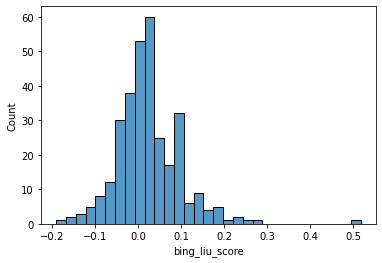

In [18]:
import seaborn
seaborn.histplot(data = lyrics_data[lyrics_data['artist']=='cher'], x = 'bing_liu_score')

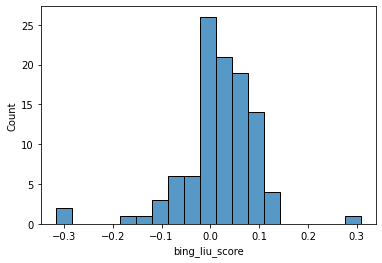

In [19]:
seaborn.histplot(data = lyrics_data[lyrics_data['artist']=='robyn'], x = 'bing_liu_score')

## Sentiment Analysis on Twitter Descriptions

In this section, define two sets of emojis you designate as positive and negative. Make sure to have at least 10 emojis per set. You can learn about the most popular emojis on Twitter at [the emojitracker](https://emojitracker.com/). 

Associate your positive emojis with a score of +1, negative with -1. Score the average sentiment of your two artists based on the Twitter descriptions of their followers. The average sentiment can just be the total score divided by number of followers. 

In [20]:
def tokenize(text):
    return re.findall(r'[\w-]*\p{L}[\w-]*', text)


def remove_punctuation(text, exceptions=None):
    all_but = [
        r'\w',
        r'\s']
        #text (str): The text to remove punctuation from.
        #exceptions (list): List of symbols to keep in the given text.
    
    if exceptions is not None:
        all_but.extend(exceptions)

    pattern = '[^{}]'.format(''.join(all_but))

    return re.sub(pattern, '', text) 

    stopwords = set(nltk.corpus.stopwords.words('english'))
    def remove_stop(tokens):
        return [t for t in tokens if t.lower() not in stopwords]

my_pipeline = [str.lower, remove_punctuation, tokenize, remove_stop]

def prepare(text, pipeline): 
    token = text
    for transform in pipeline: 
        token = transform(token)
        return token

#Convert dataframes to string
lyrics_data['lyrics'] = lyrics_data['text'].map(str)
twitter_data['description'] = twitter_data['description'].map(str)

#Apply pipeline
lyrics_data['tokens'] = lyrics_data['lyrics'].apply(prepare, pipeline= my_pipeline)

lyrics_data["tokens"] = lyrics_data["text"].apply(prepare,pipeline=my_pipeline)
lyrics_data["num_tokens"] = lyrics_data["tokens"].map(len) 

twitter_data["tokens"] = twitter_data["description"].apply(prepare,pipeline=my_pipeline)
twitter_data["num_tokens"] = twitter_data["tokens"].map(len) 

In [21]:
twitter_data['has_emoji'] = twitter_data["description"].apply(contains_emoji)

In [22]:
twitter_data['tokens'] = twitter_data['description'].map(word_tokenize)
lyrics_data['tokens'] = lyrics_data['tokens'].map(word_tokenize)

In [23]:
follower_emoji = twitter_data[twitter_data.has_emoji].sample(10)[["artist","description","tokens"]]
follower_emoji.head(3)

,artist,description,tokens
472114,cher,bi Trust nun 😒💣 Just a youngin living life to ...,"[bi, Trust, nun, 😒💣, Just, a, youngin, living,..."
862148,cher,🍬 (last account got deleted big sad),"[🍬, (, last, account, got, deleted, big, sad, )]"
756038,cher,#VoteThemOut #TakeAKnee #AntiRacist #Resistanc...,"[#, VoteThemOut, #, TakeAKnee, #, AntiRacist, ..."


In [24]:
emoji_summary = adv.extract_emoji(follower_emoji)
follower_emoji = emoji_summary['emoji_text']

Q: What is the average sentiment of your two artists? 

A: <!-- Your answer here --> 

---

Q: Which positive emoji is the most popular for each artist? Which negative emoji? 

A: <!-- Your answer here --> 

